In [23]:
import pandas as pd
import matplotlib

# loads origin csv data
hotels = pd.read_csv("hotels_data.csv").head(200)

# Group by hotel name
hotelgrouped = hotels.groupby(['Hotel Name'])

# Sort by count and take first 150
releHotels = hotelgrouped.agg(['count'])['Days'].sort_values(by=['count'], ascending=False)
releHotels = releHotels.head(150)

# Take only that hotels' data
hotels = hotels.loc[hotels['Hotel Name'].isin(releHotels.index)]

# Group by check in date
dateGrouped = hotels.groupby(['Checkin Date'])

# Sort by count and take first 40
releDates = dateGrouped.agg(['count'])['Days'].sort_values(by=['count'], ascending=False)
releDates = releDates.head(40)

# Take only that Checkin Date' data
hotels = hotels.loc[hotels['Checkin Date'].isin(releDates.index)]
hotelgrouped = hotels.groupby(['Hotel Name'])

In [25]:
# Get Dates as a list
dateslst = releDates.index.values

# Create a list of hotels that contains a list of discount codes across dates
tempLst = list(map(lambda date: list(map(lambda disCode: date + "-" + str(disCode),[1,2,3,4])),dateslst))

# Flatten the list
finalLst = [item for sublist in tempLst for item in sublist]

# Create a new dataframe
# it's columns - hotel name and the created list
clusterDf = pd.DataFrame(columns=['Hotel Name'] + finalLst)

hotelgrouped = hotels.groupby(['Hotel Name'])
hotelgrouped
# Go over every group of hotel
for htlName, htlGroup in hotelgrouped:
    # Create Current Hotel Row
    htlCurrRow = {'Hotel Name': htlName}
    
    # Group by Checkin Date
    currDateGrouped = htlGroup.groupby(['Checkin Date'])
    # Go over every Checkin Date in current hotel
    for chkName, chkGroup in currDateGrouped:
        # Group by Discount Code
        dCodeGrouped = htlGroup.groupby(['Discount Code'])
        
        # Go over every Discount Code in current Checkin Date
        for dCodeName, dCodeGroup in dCodeGrouped:
            
            # Get index of the minimun price for current parameters
            rowIdx = dCodeGroup['Discount Price'].idxmin(axis=1)
            
            # Extract the value
            lowPrice = dCodeGroup.loc[rowIdx]['Discount Price']
            
            # Set for current hotel,checkin and discount code value
            htlCurrRow[chkName + "-" + str(dCodeName)] = lowPrice
    
    # Add the created hotel row to the clustering dataframe
    clusterDf = clusterDf.append(htlCurrRow, ignore_index=True)

# Add missing values to a default -1
clusterDf = clusterDf.fillna(-1)

In [26]:
import math

# Normalize according to the ratio of current price to max price
def normalize(maxi, mini, val):
    if (maxi == mini):
        return 100
    else:
        return (float(val - mini) / (maxi - mini)) * 100

# Create dataframe with no names for normalization 
clusterVals = clusterDf.drop('Hotel Name', axis=1)

# Go over rows and normalize each one:
for rowIdx, row in  clusterVals.iterrows():
    
    # Reset current maximum and minimum
    currMax = row.max()
    currMin = currMax
    
    # Go over every column and find minimum value
    for col in clusterVals:
        
        # Checks if current cell's value is different than -1 and smaller than current minimum value
        if row[col] != -1 and row[col] < currMin:
            currMin = row[col]
    
    # Normalize curr row cells
    clusterDf.iloc[rowIdx,1:161] = clusterDf.iloc[rowIdx,1:161].apply(lambda val: -1 if val == -1 else normalize(currMax, currMin, val))

#clusterDf

#### Markdown cell

Populating the interactive namespace from numpy and matplotlib


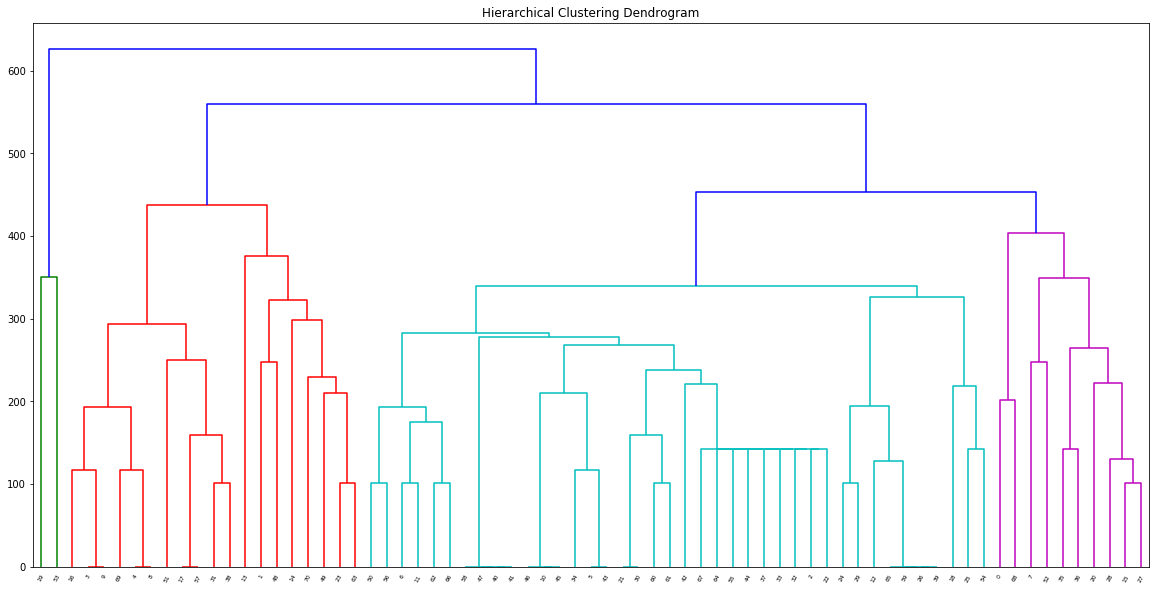

In [27]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

clusterVals = clusterDf.drop('Hotel Name', axis=1)
linkage_matrix = linkage(clusterVals, 'ward')
dendrogram(
    linkage_matrix,
    truncate_mode="lastp",  # show only the last p merged clusters
    p=149,  # show only the last p merged clusters
    show_leaf_counts=True,  # numbers in brackets are counts, others idx
    leaf_rotation=60.,
    leaf_font_size=6.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.title('Hierarchical Clustering Dendrogram')
plt.axhline(y=2400)
plt.axhline(y=1600)
plt.axhline(y=800)
plt.show()